Final Project

Name: Maybel Herrera

SUID:244416610

In [2]:
 #Import libraries
 !pip -q install kagglehub
import kagglehub
import os, glob
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from PIL import Image
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import random
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import roc_curve, auc




SEED = 42

os.environ["PYTHONHASHSEED"] = str(SEED)
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)





Extraxt Dataset directly from kagglehub

In [3]:
dataset_dir = kagglehub.dataset_download("ronakp004/autism-spectrum-detection-from-kaggle-zenodo")
print("Dataset downloaded to:", dataset_dir)


Using Colab cache for faster access to the 'autism-spectrum-detection-from-kaggle-zenodo' dataset.
Dataset downloaded to: /kaggle/input/autism-spectrum-detection-from-kaggle-zenodo


In [4]:

candidates = glob.glob(os.path.join(dataset_dir, "**", "old_dataset"), recursive=True)
print("old_dataset folders found:", candidates)




old_dataset folders found: ['/kaggle/input/autism-spectrum-detection-from-kaggle-zenodo/old_dataset', '/kaggle/input/autism-spectrum-detection-from-kaggle-zenodo/old_dataset/old_dataset']


In [5]:
old_root = glob.glob(os.path.join(dataset_dir, "**", "old_dataset", "old_dataset"), recursive=True)
old_root = old_root[0] if old_root else candidates[0]
print("Using old dataset root:", old_root)

autistic_dir = os.path.join(old_root, "Autistic")
non_autistic_dir = os.path.join(old_root, "Non-Autistic")
print("Autistic dir:", autistic_dir)
print("Non-Autistic dir:", non_autistic_dir)


Using old dataset root: /kaggle/input/autism-spectrum-detection-from-kaggle-zenodo/old_dataset/old_dataset
Autistic dir: /kaggle/input/autism-spectrum-detection-from-kaggle-zenodo/old_dataset/old_dataset/Autistic
Non-Autistic dir: /kaggle/input/autism-spectrum-detection-from-kaggle-zenodo/old_dataset/old_dataset/Non-Autistic


Dataframe for light EDA

In [6]:
img_exts = ("*.jpg", "*.jpeg", "*.png", "*.webp")

autistic_paths = []
non_autistic_paths = []

for ext in img_exts:
    autistic_paths += glob.glob(os.path.join(autistic_dir, "**", ext), recursive=True)
    non_autistic_paths += glob.glob(os.path.join(non_autistic_dir, "**", ext), recursive=True)

df = pd.DataFrame({
    "file_path": autistic_paths + non_autistic_paths,
    "label": ["autism"] * len(autistic_paths) + ["non_autism"] * len(non_autistic_paths)
})
print("Labels:", df['label'].unique())
print("Total images:", len(df))
print(df["label"].value_counts())


df.head()


Labels: ['autism' 'non_autism']
Total images: 3620
label
autism        1887
non_autism    1733
Name: count, dtype: int64


,file_path,label
0,/kaggle/input/autism-spectrum-detection-from-k...,autism
1,/kaggle/input/autism-spectrum-detection-from-k...,autism
2,/kaggle/input/autism-spectrum-detection-from-k...,autism
3,/kaggle/input/autism-spectrum-detection-from-k...,autism
4,/kaggle/input/autism-spectrum-detection-from-k...,autism


Very close distribution between the two labels

label
autism        1887
non_autism    1733
Name: count, dtype: int64


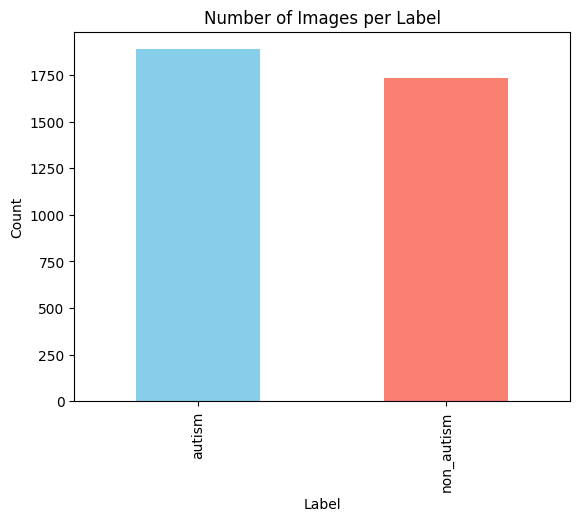

In [7]:
print(df['label'].value_counts())


 #Bar graph of label counts

df['label'].value_counts().plot(kind='bar', color=['skyblue', 'salmon'])
plt.title('Number of Images per Label')
plt.xlabel('Label')
plt.ylabel('Count')
plt.show()

Check missing values

In [8]:
print("Missing values:\n", df.isnull().sum())


Missing values:
 file_path    0
label        0
dtype: int64


Check pixel size . Since images do vary in size we need to resize before training .

In [9]:


for i in range(3):  # check 3 sample images
    img = Image.open(df['file_path'][i])
    print(f"Image {i+1}: size = {img.size}, mode = {img.mode}")


Image 1: size = (249, 299), mode = RGB
Image 2: size = (368, 438), mode = RGB
Image 3: size = (277, 288), mode = RGB


View samples to check iamge quality

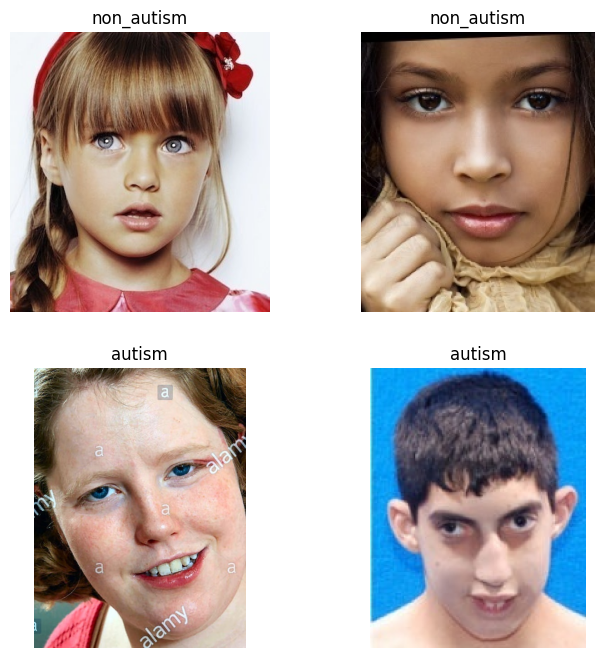

In [10]:


sample = df.sample(4)
plt.figure(figsize=(8,8))
for i, row in enumerate(sample.itertuples(), 1):
    img = Image.open(row.file_path)
    plt.subplot(2,2,i)
    plt.imshow(img)
    plt.title(row.label)
    plt.axis("off")
plt.show()


Split in to training , validation testing

In [11]:


DATA_DIR = old_root
IMG_SIZE = (224, 224)
BATCH_SIZE = 32
SEED = 123

# Training set
train_ds = tf.keras.utils.image_dataset_from_directory(
    DATA_DIR,
    validation_split=0.30,
    subset="training",
    seed=SEED,
    shuffle=True,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
)

# Full 30% split that we'll divide into val + test
val_full = tf.keras.utils.image_dataset_from_directory(
    DATA_DIR,
    validation_split=0.30,
    subset="validation",
    seed=SEED,
    shuffle=True,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
)

val_batches = tf.data.experimental.cardinality(val_full)

# Half for test, half for validation
test_ds = val_full.take(val_batches // 2)
val_ds  = val_full.skip(val_batches // 2)

Found 3620 files belonging to 2 classes.
Using 2534 files for training.
Found 3620 files belonging to 2 classes.
Using 1086 files for validation.


Check distribution counts

In [12]:


def count_labels(dataset):
    """Extract label counts from a tf.data dataset."""
    labels = []
    for _, y in dataset:
        labels.extend(y.numpy().astype(int))
    labels = np.array(labels)
    unique, counts = np.unique(labels, return_counts=True)
    return dict(zip(unique, counts))


# Count labels
train_counts = count_labels(train_ds)
val_counts   = count_labels(val_ds)
test_counts  = count_labels(test_ds)

print("Train:", train_counts)
print("Validation:", val_counts)
print("Test:", test_counts)


Train: {np.int64(0): np.int64(1345), np.int64(1): np.int64(1189)}
Validation: {np.int64(0): np.int64(272), np.int64(1): np.int64(270)}
Test: {np.int64(0): np.int64(271), np.int64(1): np.int64(273)}


Visulaized distributin counts

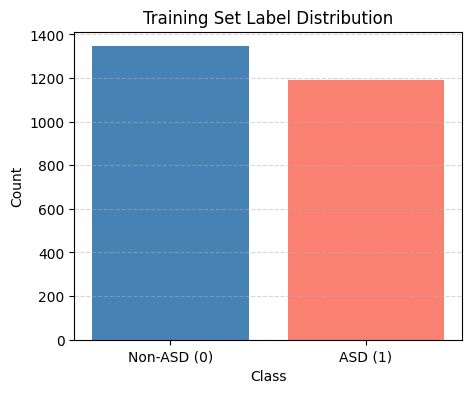

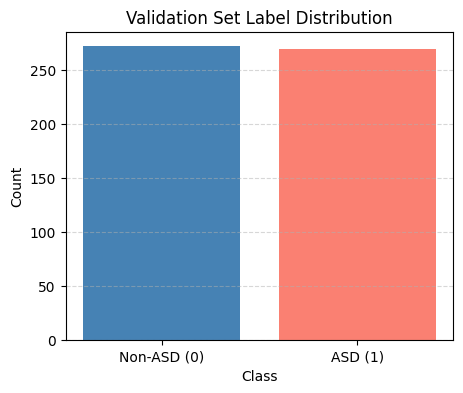

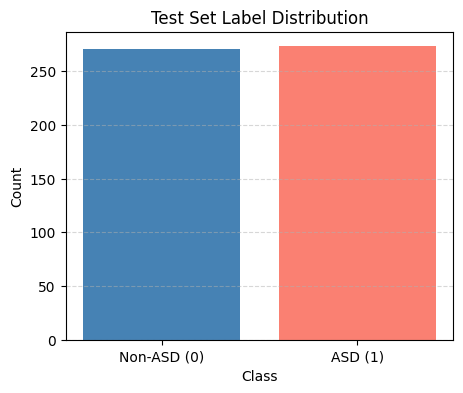

In [13]:
def plot_bar(counts, title):
    labels = ["Non-ASD (0)", "ASD (1)"]
    values = [counts.get(0, 0), counts.get(1, 0)]

    plt.figure(figsize=(5,4))
    plt.bar(labels, values, color=["steelblue", "salmon"])
    plt.title(title)
    plt.xlabel("Class")
    plt.ylabel("Count")
    plt.grid(axis="y", linestyle="--", alpha=0.5)
    plt.show()

plot_bar(train_counts, "Training Set Label Distribution")
plot_bar(val_counts,   "Validation Set Label Distribution")
plot_bar(test_counts,  "Test Set Label Distribution")


Visualizing the data from the training data set

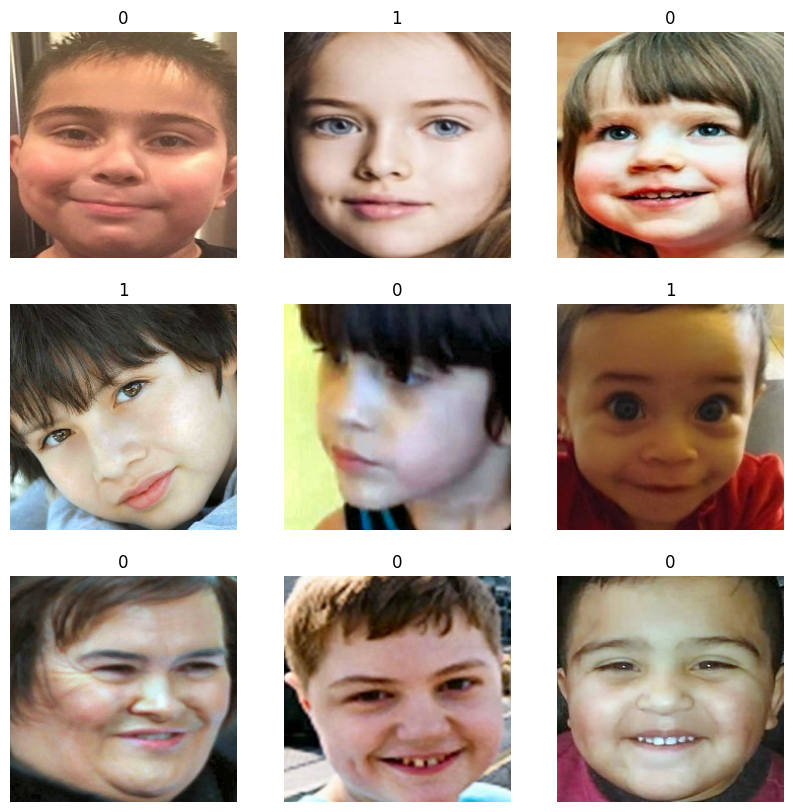

In [14]:


# specifying the size of the plot
plt.figure(figsize = (10, 10))

# train_ds.take(1) selects the first batch of 32 images
for images, labels in train_ds.take(1):

    # inner for loop for visualizing images in grid
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype('uint8'))
        plt.title(int(labels[i]))
        plt.axis('off')

Data Augmentation

In [15]:
data_augmentation = keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.05),
    layers.RandomZoom(0.05),

], name="data_aug")

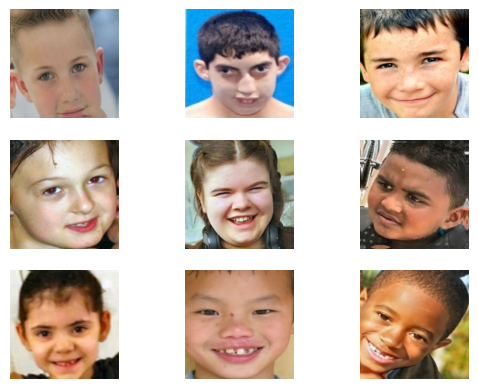

In [16]:
for images, _ in train_ds.take(1):
    augmented_images = data_augmentation(images)
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_images[i].numpy().astype('uint8'))
        plt.axis('off')
plt.show()


CNN Model

In [17]:


inputs = keras.Input(shape=(IMG_SIZE[0], IMG_SIZE[1], 3))

#  Augmentation – only applied during training
x = data_augmentation(inputs)

#  Rescale pixels from [0,255] → [0,1]
x = layers.Rescaling(1./255)(x)

#  Convolution blocks
x = layers.Conv2D(32, (3,3), padding='same', activation='relu')(x)
x = layers.MaxPooling2D(2,2)(x)

x = layers.Conv2D(64, (3,3), padding='same', activation='relu')(x)
x = layers.Dropout(0.2)(x)
x = layers.MaxPooling2D(2,2)(x)

x = layers.Conv2D(128, (3,3), padding='same', activation='relu')(x)
x = layers.Dropout(0.3)(x)
x = layers.MaxPooling2D(2,2)(x)

x = layers.Conv2D(256, (3,3), padding='same', activation='relu')(x)
x = layers.Dropout(0.3)(x)
x = layers.MaxPooling2D(2,2)(x)


#  Dense classifier
x = layers.Flatten()(x)
x = layers.Dense(128, activation='relu')(x)
x = layers.Dropout(0.6)(x)   # helps with overfitting

# Binary classification: autistic / non-autistic
outputs = layers.Dense(1, activation='sigmoid')(x)

model = keras.Model(inputs, outputs, name="asd_cnn_model")

In [18]:
model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)

model.summary()


Model: "asd_cnn_model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ data_aug (Sequential)           │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling (Rescaling)           │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 224, 224, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 112, 112, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 56, 56, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 28, 28, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 28, 28, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 14, 14, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 50176)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     6,422,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,811,201 (25.98 MB)

 Trainable params: 6,811,201 (25.98 MB)

 Non-trainable params: 0 (0.00 B)

Create and add callbacks

In [19]:
cb_early = keras.callbacks.EarlyStopping(
    monitor="val_loss",
    patience=5,
    restore_best_weights=True
)

cb_rlrop = keras.callbacks.ReduceLROnPlateau(
    monitor="val_loss",
    factor=0.5,
    patience=2,
    min_lr=1e-6,
    verbose=1
)

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=40,
    callbacks=[cb_early, cb_rlrop],
    verbose=1
)
print("Training accuracy:", history.history['accuracy'][-1])


Epoch 1/40
80/80 ━━━━━━━━━━━━━━━━━━━━ 12s 64ms/step - accuracy: 0.5142 - loss: 0.8934 - val_accuracy: 0.5092 - val_loss: 0.6561 - learning_rate: 0.0010
Epoch 2/40
80/80 ━━━━━━━━━━━━━━━━━━━━ 4s 55ms/step - accuracy: 0.5561 - loss: 0.6829 - val_accuracy: 0.7140 - val_loss: 0.6611 - learning_rate: 0.0010
Epoch 3/40
80/80 ━━━━━━━━━━━━━━━━━━━━ 4s 54ms/step - accuracy: 0.6348 - loss: 0.6495 - val_accuracy: 0.7066 - val_loss: 0.6168 - learning_rate: 0.0010
Epoch 4/40
80/80 ━━━━━━━━━━━━━━━━━━━━ 4s 54ms/step - accuracy: 0.6664 - loss: 0.6180 - val_accuracy: 0.6993 - val_loss: 0.5635 - learning_rate: 0.0010
Epoch 5/40
80/80 ━━━━━━━━━━━━━━━━━━━━ 4s 55ms/step - accuracy: 0.6890 - loss: 0.5952 - val_accuracy: 0.7140 - val_loss: 0.5487 - learning_rate: 0.0010
Epoch 6/40
80/80 ━━━━━━━━━━━━━━━━━━━━ 4s 54ms/step - accuracy: 0.6841 - loss: 0.5920 - val_accuracy: 0.7362 - val_loss: 0.5353 - learning_rate: 0.0010
Epoch 7/40
80/80 ━━━━━━━━━━━━━━━━━━━━ 4s 53ms/step - accuracy: 0.7221 - loss: 0.5574 - val_ac

In [20]:
print("Training accuracy:", history.history['accuracy'][-1])

Training accuracy: 0.874112069606781


Evaluate Model with testing set

In [21]:
score = model.evaluate(test_ds, verbose=0)
print("Test loss:", score[0])
print("Test accuracy:", score[1])


Test loss: 0.41481664776802063
Test accuracy: 0.8363970518112183


Line charts for training and validation accuracy and loss

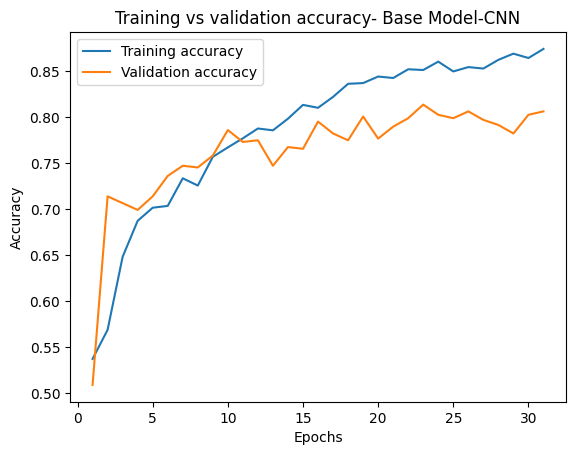

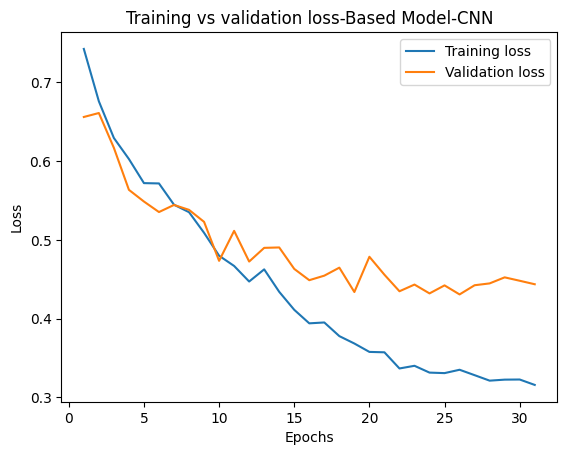

In [22]:


#  Get values from history
acc      = history.history['accuracy']
val_acc  = history.history['val_accuracy']
loss     = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

#  Plot accuracy
plt.figure()
plt.plot(epochs, acc, label='Training accuracy')
plt.plot(epochs, val_acc, label='Validation accuracy')
plt.title('Training vs validation accuracy- Base Model-CNN')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plot loss
plt.figure()
plt.plot(epochs, loss, label='Training loss')
plt.plot(epochs, val_loss, label='Validation loss')
plt.title('Training vs validation loss-Based Model-CNN')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


ROC Curve and AUC for Model Performance Evaluation

---



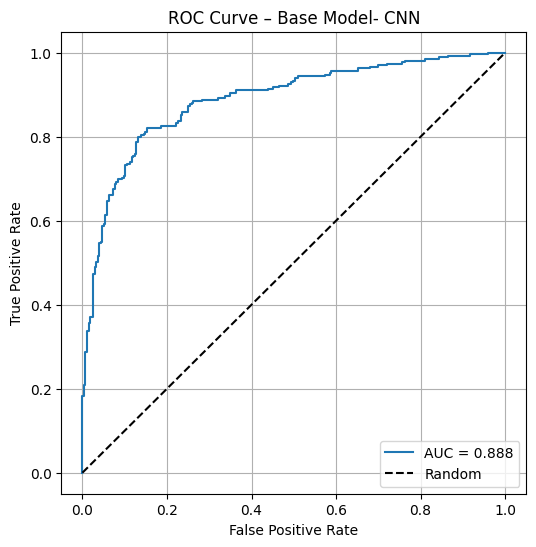

AUC: 0.8879486312943563


In [23]:


# ---- Single-pass loop to keep labels and predictions aligned ----
y_true_all = []
y_prob_all = []

for batch_x, batch_y in test_ds:
    batch_prob = model.predict_on_batch(batch_x).ravel()
    y_prob_all.append(batch_prob)
    y_true_all.append(batch_y.numpy().ravel())

y_true = np.concatenate(y_true_all, axis=0)
y_pred_prob_cnn = np.concatenate(y_prob_all, axis=0)

# ---- ROC curve ----
fpr, tpr, _ = roc_curve(y_true, y_pred_prob_cnn)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6,6))
plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.3f}")
plt.plot([0, 1], [0, 1], 'k--', label="Random")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve – Base Model- CNN")
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

print("AUC:", roc_auc)




Confusion Matrix Evaluation

Confusion Matrix:
 [[231  44]
 [ 48 221]]

Classification Report:
              precision    recall  f1-score   support

           0      0.828     0.840     0.834       275
           1      0.834     0.822     0.828       269

    accuracy                          0.831       544
   macro avg      0.831     0.831     0.831       544
weighted avg      0.831     0.831     0.831       544



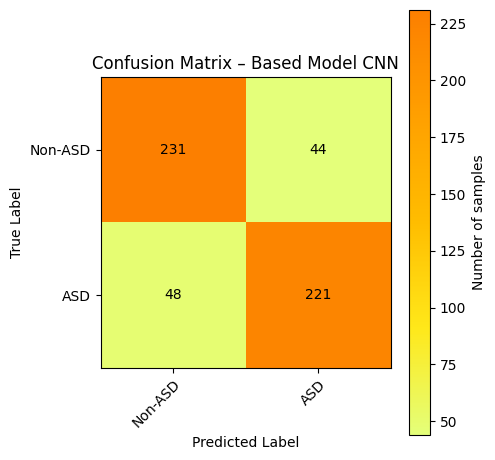

In [27]:

# ---- Confusion matrix ----
threshold = 0.5
y_pred_class_cnn = (y_pred_prob_cnn >= threshold).astype(int)

cm = confusion_matrix(y_true, y_pred_class_cnn)
print("Confusion Matrix:\n", cm)

print("\nClassification Report:")
print(classification_report(y_true, y_pred_class_cnn, digits=3))

classes = ["Non-ASD", "ASD"]

fig, ax = plt.subplots(figsize=(5,5))
im = ax.imshow(cm, interpolation="nearest", cmap="Wistia")



cbar=plt.colorbar(im, ax=ax)
cbar.set_label("Number of samples")



ax.set_xticks(np.arange(len(classes)))
ax.set_yticks(np.arange(len(classes)))
ax.set_xticklabels(classes)
ax.set_yticklabels(classes)
ax.set_xlabel("Predicted Label")
ax.set_ylabel("True Label")
ax.set_title("Confusion Matrix – Based Model CNN")

plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")

for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax.text(j, i, cm[i, j], ha="center", va="center", color="black")


plt.tight_layout()
plt.show()


Transfer Learning Model

In [28]:


base = MobileNetV2(
    input_shape=IMG_SIZE + (3,),
    include_top=False,
    weights="imagenet"
)

# PHASE 1: feature extractor (all frozen)
base.trainable = False

inputs = keras.Input(shape=IMG_SIZE + (3,))
x = data_augmentation(inputs)
x = preprocess_input(x)
x = base(x, training=False)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0.3)(x)
x = layers.Dense(128, activation="relu")(x)
x = layers.Dropout(0.3)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)

model_tl = keras.Model(inputs, outputs, name="model_tl_mobilenetv2")
model_tl.summary()





9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "model_tl_mobilenetv2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ data_aug (Sequential)           │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ true_divide (TrueDivide)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ subtract (Subtract)             │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │       163,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,422,081 (9.24 MB)

 Trainable params: 164,097 (641.00 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [29]:
# --- Callbacks ---
cb_ckpt_tl = keras.callbacks.ModelCheckpoint(
    "best_mobilenetv2.keras",
    monitor="val_loss",
    mode="min",
    save_best_only=True,
    verbose=1
)

cb_early_tl = keras.callbacks.EarlyStopping(
    monitor="val_loss",
    patience=5,
    restore_best_weights=True,
    verbose=1
)

cb_rlrop_tl = keras.callbacks.ReduceLROnPlateau(
    monitor="val_loss",
    factor=0.5,
    patience=2,
    min_lr=1e-6,
    verbose=1
)


In [30]:
# ---------- PHASE 1: train top layers only ----------
model_tl.compile(
    optimizer=keras.optimizers.Adam(1e-3),
    loss="binary_crossentropy",
    metrics=["accuracy"]
)
history_tl_p1 = model_tl.fit(
    train_ds,
    validation_data=val_ds,
    epochs=10,
    callbacks=[cb_early_tl, cb_rlrop_tl, cb_ckpt_tl],
    verbose=1
)
print("Training accuracy:", history_tl_p1.history['accuracy'][-1])

Epoch 1/10
79/80 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.6338 - loss: 0.6824
Epoch 1: val_loss improved from inf to 0.51141, saving model to best_mobilenetv2.keras
80/80 ━━━━━━━━━━━━━━━━━━━━ 10s 65ms/step - accuracy: 0.6349 - loss: 0.6807 - val_accuracy: 0.7472 - val_loss: 0.5114 - learning_rate: 0.0010
Epoch 2/10
79/80 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.7285 - loss: 0.5363
Epoch 2: val_loss improved from 0.51141 to 0.46483, saving model to best_mobilenetv2.keras
80/80 ━━━━━━━━━━━━━━━━━━━━ 4s 45ms/step - accuracy: 0.7286 - loss: 0.5361 - val_accuracy: 0.7657 - val_loss: 0.4648 - learning_rate: 0.0010
Epoch 3/10
79/80 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.7483 - loss: 0.5037
Epoch 3: val_loss did not improve from 0.46483
80/80 ━━━━━━━━━━━━━━━━━━━━ 3s 39ms/step - accuracy: 0.7484 - loss: 0.5036 - val_accuracy: 0.7454 - val_loss: 0.4902 - learning_rate: 0.0010
Epoch 4/10
79/80 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.7701 - loss: 0.4763
Epoch 4: Reduc

In [31]:
# ---------- PHASE 2: fine-tune last N layers ----------

for layer in base.layers[-30:]:
    layer.trainable = True

model_tl.compile(
    optimizer=keras.optimizers.Adam(5e-5),
    loss="binary_crossentropy",
    metrics=["accuracy"]
)

model_tl.summary()

Model: "model_tl_mobilenetv2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ data_aug (Sequential)           │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ true_divide (TrueDivide)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ subtract (Subtract)             │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │       163,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,422,081 (9.24 MB)

 Trainable params: 1,690,497 (6.45 MB)

 Non-trainable params: 731,584 (2.79 MB)

In [32]:
history_tl_p2 = model_tl.fit(
    train_ds,
    validation_data=val_ds,
    epochs=20,
    callbacks=[cb_early_tl, cb_rlrop_tl, cb_ckpt_tl],
    verbose=1
)

print("Training accuracy:", history_tl_p2.history['accuracy'][-1])

Epoch 1/20
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.7116 - loss: 0.5801
Epoch 1: val_loss did not improve from 0.43864
80/80 ━━━━━━━━━━━━━━━━━━━━ 16s 77ms/step - accuracy: 0.7121 - loss: 0.5795 - val_accuracy: 0.7362 - val_loss: 0.5541 - learning_rate: 5.0000e-05
Epoch 2/20
79/80 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.7936 - loss: 0.4354
Epoch 2: val_loss did not improve from 0.43864
80/80 ━━━━━━━━━━━━━━━━━━━━ 4s 49ms/step - accuracy: 0.7937 - loss: 0.4353 - val_accuracy: 0.7952 - val_loss: 0.4745 - learning_rate: 5.0000e-05
Epoch 3/20
79/80 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.8274 - loss: 0.3827
Epoch 3: val_loss did not improve from 0.43864
80/80 ━━━━━━━━━━━━━━━━━━━━ 4s 50ms/step - accuracy: 0.8276 - loss: 0.3823 - val_accuracy: 0.7970 - val_loss: 0.4489 - learning_rate: 5.0000e-05
Epoch 4/20
79/80 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - accuracy: 0.8461 - loss: 0.3515
Epoch 4: val_loss improved from 0.43864 to 0.39521, saving model to best_mobilenetv2.k

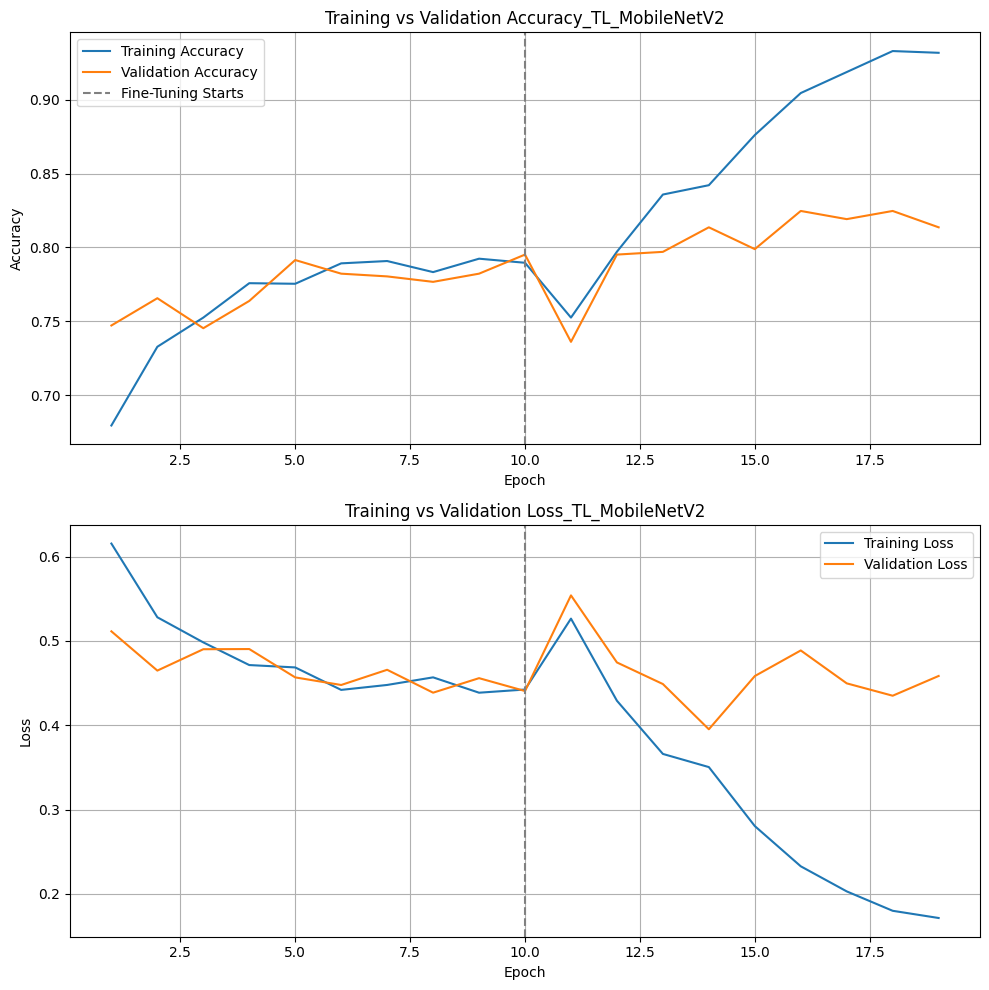

In [33]:



# --- Extract Phase 1 ---
acc_p1       = history_tl_p1.history["accuracy"]
val_acc_p1   = history_tl_p1.history["val_accuracy"]
loss_p1      = history_tl_p1.history["loss"]
val_loss_p1  = history_tl_p1.history["val_loss"]

# --- Extract Phase 2 ---
acc_p2       = history_tl_p2.history["accuracy"]
val_acc_p2   = history_tl_p2.history["val_accuracy"]
loss_p2      = history_tl_p2.history["loss"]
val_loss_p2  = history_tl_p2.history["val_loss"]

# --- Combine epochs ---
acc_all      = acc_p1 + acc_p2
val_acc_all  = val_acc_p1 + val_acc_p2
loss_all     = loss_p1 + loss_p2
val_loss_all = val_loss_p1 + val_loss_p2

epochs_all = range(1, len(acc_all) + 1)
phase1_end = len(acc_p1)

plt.figure(figsize=(10, 10))

# ===== Plot Accuracy =====

plt.subplot(2, 1, 1)
plt.plot(epochs_all, acc_all, label="Training Accuracy")
plt.plot(epochs_all, val_acc_all, label="Validation Accuracy")
plt.axvline(x=phase1_end, color='gray', linestyle='--', label="Fine-Tuning Starts")
plt.title("Training vs Validation Accuracy_TL_MobileNetV2")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True)

# ===== Plot Loss =====
plt.subplot(2, 1, 2)
plt.plot(epochs_all, loss_all, label="Training Loss")
plt.plot(epochs_all, val_loss_all, label="Validation Loss")
plt.axvline(x=phase1_end, color='gray', linestyle='--')
plt.title("Training vs Validation Loss_TL_MobileNetV2")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)

plt.tight_layout()

plt.show()



In [34]:
# ========= BLOCK: FINAL TEST EVALUATION =========
best_tl = keras.models.load_model("best_mobilenetv2.keras", compile=False)
best_tl.compile(
    optimizer=keras.optimizers.Adam(5e-5),
    loss="binary_crossentropy",
    metrics=["accuracy"]
)

test_loss, test_acc = best_tl.evaluate(test_ds, verbose=0)
print(f"Test loss: {test_loss:.4f}")
print(f"Test accuracy: {test_acc:.4f}")


Test loss: 0.4362
Test accuracy: 0.8143


In [35]:



y_true_all = []
y_prob_all = []

for batch_x, batch_y in test_ds:
    batch_prob = best_tl.predict_on_batch(batch_x).ravel()
    y_prob_all.append(batch_prob)
    y_true_all.append(batch_y.numpy().ravel())

y_true = np.concatenate(y_true_all, axis=0)
y_pred_prob_tl = np.concatenate(y_prob_all, axis=0)

print("Label distribution:", np.unique(y_true, return_counts=True))


Label distribution: (array([0, 1], dtype=int32), array([264, 280]))


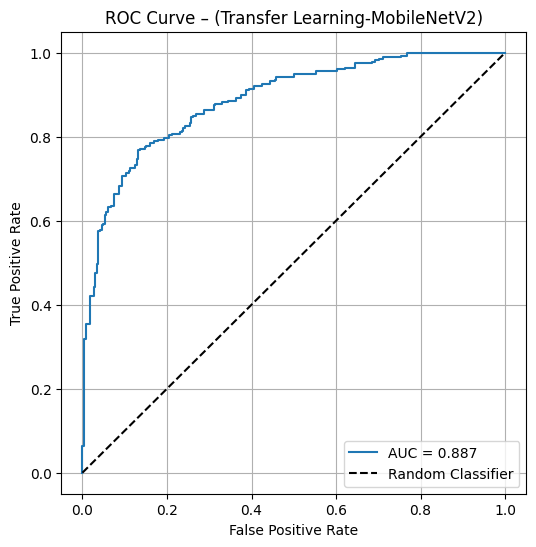

AUC: 0.8867424242424242


In [37]:
fpr, tpr, thresholds = roc_curve(y_true, y_pred_prob_tl)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6, 6))
plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.3f}")
plt.plot([0, 1], [0, 1], "k--", label="Random Classifier")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve – (Transfer Learning-MobileNetV2)")
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

print("AUC:", roc_auc)


[[215  49]
 [ 58 222]]

Classification Report:
              precision    recall  f1-score   support

           0      0.788     0.814     0.801       264
           1      0.819     0.793     0.806       280

    accuracy                          0.803       544
   macro avg      0.803     0.804     0.803       544
weighted avg      0.804     0.803     0.803       544



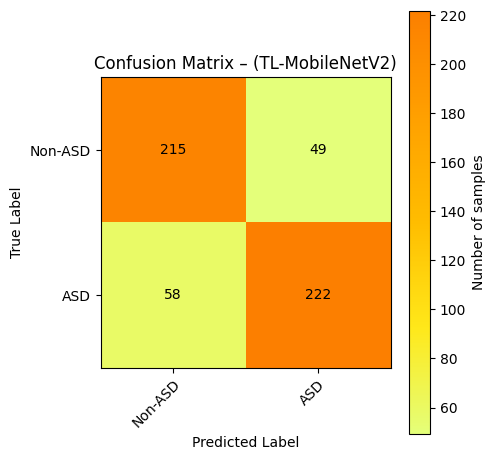

In [38]:
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import numpy as np

threshold = 0.5
y_pred_class = (y_pred_prob_tl >= threshold).astype(int)

cm = confusion_matrix(y_true, y_pred_class)
print(cm)

print("\nClassification Report:")
print(classification_report(y_true, y_pred_class, digits=3))

classes = ["Non-ASD", "ASD"]

fig, ax = plt.subplots(figsize=(5, 5))

# Plot confusion matrix
im = ax.imshow(cm, interpolation="nearest", cmap="Wistia")

#  Add colorbar
cbar = plt.colorbar(im, ax=ax)
cbar.set_label("Number of samples")

# Axis labels and ticks
ax.set_title("Confusion Matrix – (TL-MobileNetV2)")
ax.set_xticks(np.arange(len(classes)))
ax.set_yticks(np.arange(len(classes)))
ax.set_xticklabels(classes)
ax.set_yticklabels(classes)
ax.set_xlabel("Predicted Label")
ax.set_ylabel("True Label")

# Rotate x-axis labels
plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")

# Annotate cells
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax.text(j, i, cm[i, j],
                ha="center", va="center", color="black")

plt.tight_layout()
plt.show()